In [14]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim 

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt

# Note   
통계적 분석 방법론   
1. 원본 시계열에서 Trend, Seasonality 를 제거하고 남은 Residual 을 모델링
2. Residual 은 stationarity 를 기반으로 모델링(ARIMA 계열)
3. 예측은 Residual 을 토대로 만든 모델의 예측값에 Trend 와 Seasonality 를 더해 계산

In [ ]:
from bs4 import BeautifulSoup
import requests

code = '005930'
url = 'https://finance.naver.com/item/sise_day.naver?code={}'.format(code)
header = {'User-agent':'Mozilla/5.0'}
req = requests.get(url, headers=header)
html = BeautifulSoup(req.text, 'lxml')

pgrr = html.find('td', class_='pgRR')
s = pgrr.a['href'].split('=')
lat_page = s[-1]

df = None

for page in tqdm(range(1,100)):
    req = requests.get('{}&page={}'.format(url,page), headers=header)
    df = pd.concat([df, pd.read_html(req.text, encoding='euc-kr')[0]], ignore_index=True)

df.head()

In [3]:
df.dropna(inplace=True)

df.columns = ['Date', 'Close', 'Gap', 'Open', 'High', 'Low', 'Amount']

df.drop(['Gap'], axis=1, inplace=True)

df.sort_values(['Date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)

(990, 6)


In [7]:
train_df = df.loc[df.Date < '2024.04.24']
test_df = df.loc[df.Date >= '2024.04.24']
print(train_df.tail())
print(test_df)

train_df.drop(['Date'],axis=1,inplace=True)

scaler = StandardScaler()
scaler.fit(train_df)
s_train_df = scaler.transform(train_df)
s_test_df = scaler.transform(test_df.drop(['Date'], axis=1))

           Date    Close     Open     High      Low      Amount
980  2024.04.17  78900.0  80700.0  80800.0  78900.0  22611631.0
981  2024.04.18  79600.0  78800.0  80100.0  78300.0  21370190.0
982  2024.04.19  77600.0  78300.0  78700.0  76300.0  31317563.0
983  2024.04.22  76100.0  77400.0  77500.0  75100.0  30469477.0
984  2024.04.23  75500.0  76400.0  76800.0  75500.0  18717699.0
           Date    Close     Open     High      Low      Amount
985  2024.04.24  78600.0  77500.0  78800.0  77200.0  22166150.0
986  2024.04.25  76300.0  77300.0  77500.0  76300.0  15549134.0
987  2024.04.26  76700.0  77800.0  77900.0  76500.0  12755629.0
988  2024.04.29  76700.0  77400.0  77600.0  76200.0  14664474.0
989  2024.04.30  77500.0  77000.0  78500.0  76600.0  18819539.0


C:\Users\User\AppData\Local\Temp\ipykernel_8108\1979170977.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['Date'],axis=1,inplace=True)


In [8]:
input_window = 30
output_window = 5

data = torch.tensor(s_train_df, dtype=torch.float32)
target = torch.tensor(s_train_df.T[0], dtype=torch.float32)

X, Y = [], []

for i in range(len(data) - input_window - output_window + 1):
    X.append(data[i:i+input_window])
    Y.append(target[i+input_window:i+input_window+output_window])

dataset = TensorDataset(torch.stack(X), torch.stack(Y))
print(dataset[0][0].shape)
print(dataset[0][1].shape)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(len(dataloader))

torch.Size([30, 5])
torch.Size([5])
30


In [9]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.Layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        output, (h_out, c_out) = self.lstm(x)
        h_out = h_out.view(-1, self.hidden_size)
        return self.Layer(h_out)
    
model = MyRNN(5,30,5)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [13]:
num_epoch = 100
losses = []

for epoch in tqdm(range(num_epoch)):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().item())

100%|██████████| 100/100 [00:04<00:00, 21.89it/s]


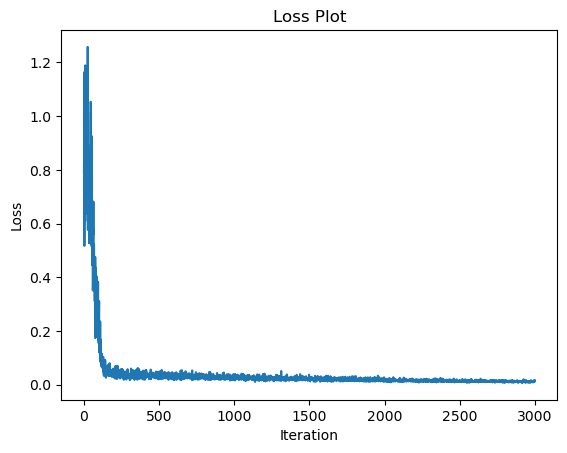

In [15]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [16]:
y_real = s_test_df.T[0]
print('real value:', y_real)

input = torch.tensor(s_train_df[-30:], dtype=torch.float32)
y_pred = model(input.to(device)).detach().cpu().squeeze().numpy()
print('predicted value: ', y_pred)

print('real closed for last 5 days: ', scaler.inverse_transform(s_test_df).T[0])
transformed_y_pred = y_pred * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
print('predicted closed for last 5 days: ', transformed_y_pred)

print("error: ", np.sqrt(mean_squared_error(transformed_y_pred, scaler.inverse_transform(s_test_df).T[0])))

real value: [1.06030296 0.81504014 0.85769454 0.85769454 0.94300335]
predicted value:  [0.8773139  0.9204346  0.89446205 0.9440888  1.0295882 ]
real closed for last 5 days:  [78600. 76300. 76700. 76700. 77500.]
predicted closed for last 5 days:  [76883.984 77288.36  77044.8   77510.18  78311.97 ]
error:  1035.00078661018
